# 1. Create Spark Session & Import Libraries

In [3]:
# if pyspark needs to be installed:
# !pip install pyspark findspark

     |████████████████████████████████| 317.2 MB 631 bytes/s a 0:00:01
     |████████████████████████████████| 200 kB 14.7 MB/s eta 0:00:01
done
  Created wheel for pyspark: filename=pyspark-3.5.5-py2.py3-none-any.whl size=317747881 sha256=d56628120b90e242e8f289edb3204e1e76b7db3bea46cb313c2720c4293412c2
  Stored in directory: /home/jj/.cache/pip/wheels/9e/5b/b4/a3ac8d456edf8c52eb15f9eb357d961812d5f17bf203c54c18
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.9
    Uninstalling py4j-0.10.9.9:
      Successfully uninstalled py4j-0.10.9.9


In [1]:
# spark libraries
import findspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, IntegerType, DoubleType, DateType, StructType, StructField

# ds libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ml libraries
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

findspark.init()

spark = SparkSession.builder \
    .appName("FlightDelayBatchProcessing") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/29 19:02:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/29 19:03:07 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


# 2. Define Schema & Data Preprocessing

In [3]:
# define schema
schema = StructType([
    StructField("FL_DATE", StringType(), True),
    StructField("AIRLINE", StringType(), True),
    StructField("AIRLINE_DOT", StringType(), True),
    StructField("AIRLINE_CODE", StringType(), True),
    StructField("DOT_CODE", IntegerType(), True),
    StructField("FL_NUMBER", IntegerType(), True),
    StructField("ORIGIN", StringType(), True),
    StructField("ORIGIN_CITY", StringType(), True),
    StructField("DEST", StringType(), True),
    StructField("DEST_CITY", StringType(), True),
    StructField("CRS_DEP_TIME", IntegerType(), True),
    StructField("DEP_TIME", DoubleType(), True),
    StructField("DEP_DELAY", DoubleType(), True),
    StructField("TAXI_OUT", DoubleType(), True),
    StructField("WHEELS_OFF", DoubleType(), True),
    StructField("WHEELS_ON", DoubleType(), True),
    StructField("TAXI_IN", DoubleType(), True),
    StructField("CRS_ARR_TIME", IntegerType(), True),
    StructField("ARR_TIME", DoubleType(), True),
    StructField("ARR_DELAY", DoubleType(), True),
    StructField("CANCELLED", DoubleType(), True),
    StructField("CANCELLATION_CODE", StringType(), True),
    StructField("DIVERTED", DoubleType(), True),
    StructField("CRS_ELAPSED_TIME", DoubleType(), True),
    StructField("ELAPSED_TIME", DoubleType(), True),
    StructField("AIR_TIME", DoubleType(), True),
    StructField("DISTANCE", DoubleType(), True),
    StructField("DELAY_DUE_CARRIER", DoubleType(), True),
    StructField("DELAY_DUE_WEATHER", DoubleType(), True),
    StructField("DELAY_DUE_NAS", DoubleType(), True),
    StructField("DELAY_DUE_SECURITY", DoubleType(), True),
    StructField("DELAY_DUE_LATE_AIRCRAFT", DoubleType(), True)
])

# read in csv data file
data_path = "flight_data.csv"
df = spark.read.csv(data_path, header=True, schema=schema)

# edit formatting of flight date
df = df.withColumn("FL_DATE", F.to_date(F.col("FL_DATE"), "yyyy-MM-dd"))

### Data Checking

In [4]:
# show df schema
df.printSchema()

root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- AIRLINE_DOT: string (nullable = true)
 |-- AIRLINE_CODE: string (nullable = true)
 |-- DOT_CODE: integer (nullable = true)
 |-- FL_NUMBER: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)

In [5]:
# show 1st 5 rows of df
df.show(5, truncate=False)

25/04/29 19:04:15 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+---------------------+-------------------------+------------+--------+---------+------+-------------------+----+---------------------+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+------------+--------+--------+-----------------+-----------------+-------------+------------------+-----------------------+
|FL_DATE   |AIRLINE              |AIRLINE_DOT              |AIRLINE_CODE|DOT_CODE|FL_NUMBER|ORIGIN|ORIGIN_CITY        |DEST|DEST_CITY            |CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|DELAY_DUE_CARRIER|DELAY_DUE_WEATHER|DELAY_DUE_NAS|DELAY_DUE_SECURITY|DELAY_DUE_LATE_AIRCRAFT|
+----------+---------------------+-------------------------+------------+--------+---------+------+-------------------+----+---------------------+

### Data Cleaning

In [6]:
# Drop Irrelevant Fields
columns_to_drop = [
    'AIRLINE_DOT', 'DOT_CODE', 'FL_NUMBER', 'ORIGIN_CITY', 'DEST_CITY',
    'DEP_TIME', 'DEP_DELAY',
    'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN',
    'ARR_TIME',
    'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED',
    'ELAPSED_TIME', 'AIR_TIME',
    'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS',
    'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT'
]
df_cleaned = df.drop(*columns_to_drop)

# Drop Nulls
df_cleaned = df_cleaned.dropna(subset=[
    "ARR_DELAY", "CRS_DEP_TIME", "CRS_ARR_TIME", "CRS_ELAPSED_TIME",
    "DISTANCE", "ORIGIN", "DEST", "AIRLINE", "AIRLINE_CODE"
])

# Outlier Handling
df_cleaned = df_cleaned.filter((F.col("CRS_ELAPSED_TIME") > 0) & (F.col("CRS_ELAPSED_TIME") < 1000))
df_cleaned = df_cleaned.filter((F.col("DISTANCE") > 0) & (F.col("DISTANCE") < 3000))

### Data Checking

In [7]:
# show df schema
df.printSchema()

root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- AIRLINE_DOT: string (nullable = true)
 |-- AIRLINE_CODE: string (nullable = true)
 |-- DOT_CODE: integer (nullable = true)
 |-- FL_NUMBER: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)

In [8]:
# show 1st 5 rows of df
df.show(5, truncate=False)

+----------+---------------------+-------------------------+------------+--------+---------+------+-------------------+----+---------------------+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+------------+--------+--------+-----------------+-----------------+-------------+------------------+-----------------------+
|FL_DATE   |AIRLINE              |AIRLINE_DOT              |AIRLINE_CODE|DOT_CODE|FL_NUMBER|ORIGIN|ORIGIN_CITY        |DEST|DEST_CITY            |CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|DELAY_DUE_CARRIER|DELAY_DUE_WEATHER|DELAY_DUE_NAS|DELAY_DUE_SECURITY|DELAY_DUE_LATE_AIRCRAFT|
+----------+---------------------+-------------------------+------------+--------+---------+------+-------------------+----+---------------------+

# 3. Feature Engineering

In [9]:
delay_threshold = 60

df_featured = df_cleaned.withColumn("SEVERE_DELAY", F.when(F.col("ARR_DELAY") >= delay_threshold, 1).otherwise(0))
df_featured = df_featured.withColumn("DEP_HOUR", (F.col("CRS_DEP_TIME") / 100).cast("integer"))
df_featured = df_featured.withColumn("DEP_MINUTE", (F.col("CRS_DEP_TIME") % 100).cast("integer"))
df_featured = df_featured.withColumn("ARR_HOUR", (F.col("CRS_ARR_TIME") / 100).cast("integer"))
df_featured = df_featured.withColumn("ARR_MINUTE", (F.col("CRS_ARR_TIME") % 100).cast("integer"))
df_featured = df_featured.withColumn("DEP_DAY_OF_WEEK", F.dayofweek(F.col("FL_DATE")))
df_featured = df_featured.withColumn("DEP_MONTH", F.month(F.col("FL_DATE")))
df_featured = df_featured.withColumn("DEP_DAY_OF_MONTH", F.dayofmonth(F.col("FL_DATE")))
df_featured = df_featured.withColumn("DEP_WEEK_OF_YEAR", F.weekofyear(F.col("FL_DATE")))
df_featured = df_featured.withColumn("IS_WEEKEND", F.when(F.col("DEP_DAY_OF_WEEK").isin([1,7]), 1).otherwise(0))
df_featured = df_featured.withColumn("DISTANCE_PER_MINUTE", F.col("DISTANCE")/(F.col("CRS_ELAPSED_TIME")+1e-6))

featureCols = [
    "AIRLINE_CODE", "ORIGIN", "DEST",
    "CRS_ELAPSED_TIME", "DISTANCE",
    "DEP_HOUR", "DEP_MINUTE", "ARR_HOUR", "ARR_MINUTE",
    "DEP_DAY_OF_WEEK", "DEP_MONTH", "DEP_DAY_OF_MONTH", "DEP_WEEK_OF_YEAR",
    "IS_WEEKEND", "DISTANCE_PER_MINUTE"
]

labelCol = "SEVERE_DELAY"

final_df = df_featured.select(featureCols + [labelCol])

In [10]:
final_df.printSchema()

root
 |-- AIRLINE_CODE: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- DEP_HOUR: integer (nullable = true)
 |-- DEP_MINUTE: integer (nullable = true)
 |-- ARR_HOUR: integer (nullable = true)
 |-- ARR_MINUTE: integer (nullable = true)
 |-- DEP_DAY_OF_WEEK: integer (nullable = true)
 |-- DEP_MONTH: integer (nullable = true)
 |-- DEP_DAY_OF_MONTH: integer (nullable = true)
 |-- DEP_WEEK_OF_YEAR: integer (nullable = true)
 |-- IS_WEEKEND: integer (nullable = false)
 |-- DISTANCE_PER_MINUTE: double (nullable = true)
 |-- SEVERE_DELAY: integer (nullable = false)



In [11]:
final_df.show(5, truncate=False)

+------------+------+----+----------------+--------+--------+----------+--------+----------+---------------+---------+----------------+----------------+----------+-------------------+------------+
|AIRLINE_CODE|ORIGIN|DEST|CRS_ELAPSED_TIME|DISTANCE|DEP_HOUR|DEP_MINUTE|ARR_HOUR|ARR_MINUTE|DEP_DAY_OF_WEEK|DEP_MONTH|DEP_DAY_OF_MONTH|DEP_WEEK_OF_YEAR|IS_WEEKEND|DISTANCE_PER_MINUTE|SEVERE_DELAY|
+------------+------+----+----------------+--------+--------+----------+--------+----------+---------------+---------+----------------+----------------+----------+-------------------+------------+
|UA          |FLL   |EWR |186.0           |1065.0  |11      |55        |15      |1         |4              |1        |9               |2               |0         |5.725806420828998  |0           |
|DL          |MSP   |SEA |235.0           |1399.0  |21      |20        |23      |15        |7              |11       |19              |46              |1         |5.953191464028973  |0           |
|UA          |D

# 4. Creating Pipeline

In [12]:
categorical_cols = ["AIRLINE_CODE", "ORIGIN", "DEST"]
numerical_cols = [col for col in featureCols if col not in categorical_cols]

indexers = [
    StringIndexer(inputCol = col, outputCol = col+'Index', handleInvalid = "keep")
    for col in categorical_cols
]

encoders = [
    OneHotEncoder(inputCol= col+'Index', outputCol = col+'OHE')
    for col in categorical_cols
]

num_vector_assembler = VectorAssembler(
    inputCols=numerical_cols,
    outputCol="NumFeatures"
)

scaler = StandardScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures", withStd=True, withMean=True)

final_vector_assembler = VectorAssembler(
    inputCols=[col+'OHE' for col in categorical_cols] + ["ScaledNumFeatures"], 
    outputCol="features"
)

In [13]:
# Build Preprocessing Pipeline
pipeline = Pipeline(stages = indexers + encoders + [num_vector_assembler, scaler, final_vector_assembler])
pipeline_model = pipeline.fit(final_df)
processed_df = pipeline_model.transform(final_df)

### Show Results

In [14]:
processed_df.printSchema()

root
 |-- AIRLINE_CODE: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- DEP_HOUR: integer (nullable = true)
 |-- DEP_MINUTE: integer (nullable = true)
 |-- ARR_HOUR: integer (nullable = true)
 |-- ARR_MINUTE: integer (nullable = true)
 |-- DEP_DAY_OF_WEEK: integer (nullable = true)
 |-- DEP_MONTH: integer (nullable = true)
 |-- DEP_DAY_OF_MONTH: integer (nullable = true)
 |-- DEP_WEEK_OF_YEAR: integer (nullable = true)
 |-- IS_WEEKEND: integer (nullable = false)
 |-- DISTANCE_PER_MINUTE: double (nullable = true)
 |-- SEVERE_DELAY: integer (nullable = false)
 |-- AIRLINE_CODEIndex: double (nullable = false)
 |-- ORIGINIndex: double (nullable = false)
 |-- DESTIndex: double (nullable = false)
 |-- AIRLINE_CODEOHE: vector (nullable = true)
 |-- ORIGINOHE: vector (nullable = true)
 |-- DESTOHE: vector (nullable = true)
 |-- NumFeatures: vector (nul

In [15]:
processed_df.select("features", labelCol).show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|features                                                                                                                                                                                                                                                                                                                   |SEVERE_DELAY|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|(790,[

# 5. Training Models

In [16]:
# Train/Test Split
model_data = processed_df.select("features", labelCol).withColumnRenamed(labelCol, "label")
train_df, test_df = model_data.randomSplit([0.8, 0.2], seed=101)

label_indexer = StringIndexer(inputCol="label", outputCol="indexedLabel")
label_indexer_model = label_indexer.fit(train_df)

train_df = label_indexer_model.transform(train_df)
test_df = label_indexer_model.transform(test_df)

In [18]:
train_df_weighted = train_df.withColumn(
    "classWeightCol",
    F.when(F.col("indexedLabel") == 0.0, 0.2).otherwise(1.0)
)

### Random Forest Model

In [19]:
rf = RandomForestClassifier(
    featuresCol="features", 
    labelCol="label", 
    numTrees=30, 
    maxDepth=5, 
    seed=101
    )

rf_model = rf.fit(train_df_weighted)

25/04/29 19:09:56 WARN MemoryStore: Not enough space to cache rdd_85_5 in memory! (computed 930.2 MiB so far)
25/04/29 19:09:56 WARN BlockManager: Persisting block rdd_85_5 to disk instead.
25/04/29 19:09:56 WARN MemoryStore: Not enough space to cache rdd_85_2 in memory! (computed 930.2 MiB so far)
25/04/29 19:09:56 WARN BlockManager: Persisting block rdd_85_2 to disk instead.
25/04/29 19:09:56 WARN MemoryStore: Not enough space to cache rdd_85_3 in memory! (computed 930.2 MiB so far)
25/04/29 19:09:56 WARN BlockManager: Persisting block rdd_85_3 to disk instead.
25/04/29 19:09:56 WARN MemoryStore: Not enough space to cache rdd_85_4 in memory! (computed 930.2 MiB so far)
25/04/29 19:09:56 WARN BlockManager: Persisting block rdd_85_4 to disk instead.
25/04/29 19:09:56 WARN MemoryStore: Not enough space to cache rdd_85_6 in memory! (computed 930.2 MiB so far)
25/04/29 19:09:56 WARN BlockManager: Persisting block rdd_85_6 to disk instead.
                                                  

### Logistic Regression Model

In [20]:
lr = LogisticRegression(
    featuresCol="features", 
    labelCol="label", 
    maxIter=30, 
    regParam=0.1, 
    elasticNetParam=0.8
)

lr_model = lr.fit(train_df_weighted)

25/04/29 19:10:29 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/04/29 19:10:29 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
                                                                                

### GBTClassifier Model

In [21]:
gbt = GBTClassifier(
    featuresCol="features", 
    labelCol="label", 
    weightCol="classWeightCol", 
    maxIter=50, 
    maxDepth=5, 
    stepSize=0.1, 
    seed=101)

gbt_model = gbt.fit(train_df_weighted)

25/04/29 19:11:39 WARN MemoryStore: Not enough space to cache rdd_174_1 in memory! (computed 884.1 MiB so far)
25/04/29 19:11:39 WARN BlockManager: Persisting block rdd_174_1 to disk instead.
25/04/29 19:11:39 WARN MemoryStore: Not enough space to cache rdd_174_3 in memory! (computed 884.1 MiB so far)
25/04/29 19:11:39 WARN BlockManager: Persisting block rdd_174_3 to disk instead.
25/04/29 19:11:39 WARN MemoryStore: Not enough space to cache rdd_174_6 in memory! (computed 884.1 MiB so far)
25/04/29 19:11:39 WARN BlockManager: Persisting block rdd_174_6 to disk instead.
                                                                                

## 6. Evaluate Models

/home/jj/.local/lib/python3.8/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



Random Forest Evaluation:
Accuracy: 0.9388
Precision: 0.8813
Recall: 0.9388
F1 Score: 0.9091


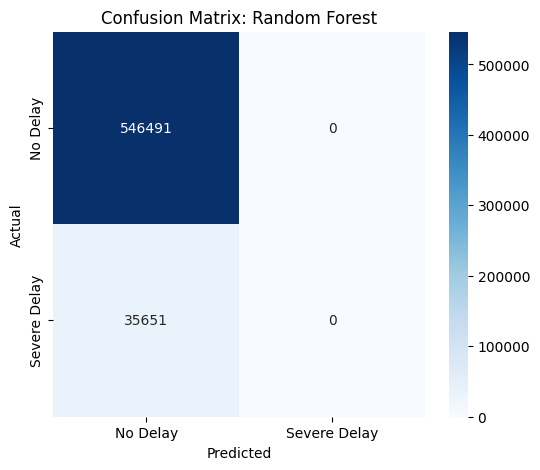


Logistic Regression Evaluation:
Accuracy: 0.9388
Precision: 0.8813
Recall: 0.9388
F1 Score: 0.9091


/home/jj/.local/lib/python3.8/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
                                                                                

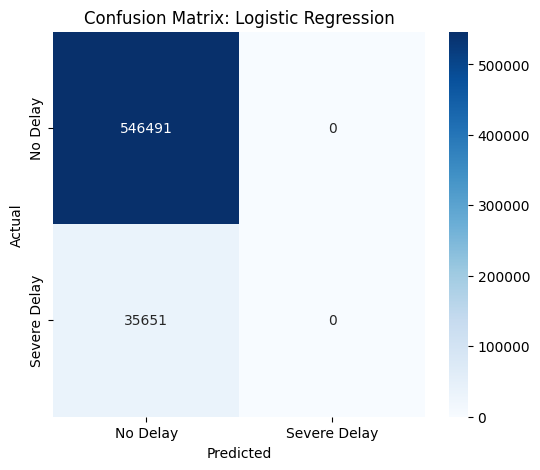

/home/jj/.local/lib/python3.8/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



GBT Evaluation:
Accuracy: 0.9298
Precision: 0.8986
Recall: 0.9298
F1 Score: 0.9108


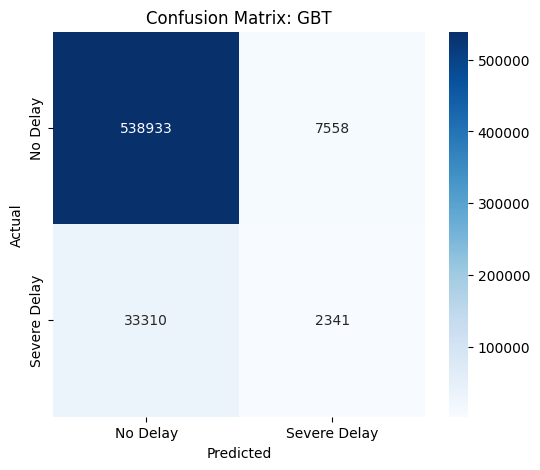

In [22]:
# Evaluate Models
models = {
    "Random Forest": rf_model,
    "Logistic Regression": lr_model,
    "GBT": gbt_model
}

for model_name, model in models.items():
    predictions = model.transform(test_df)

    evaluator = BinaryClassificationEvaluator(
        rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC"
    )
    auc = evaluator.evaluate(predictions)

    evaluator_multi = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
    accuracy = evaluator_multi.setMetricName("accuracy").evaluate(predictions)
    precision = evaluator_multi.setMetricName("weightedPrecision").evaluate(predictions)
    recall = evaluator_multi.setMetricName("weightedRecall").evaluate(predictions)
    f1 = evaluator_multi.setMetricName("f1").evaluate(predictions)

    print(f"\n{model_name} Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix
    preds_and_labels = predictions.select(
        (F.round("prediction")).alias("prediction"),
        "label"
    ).rdd.map(lambda row: (float(row.prediction), float(row.label)))

    metrics = MulticlassMetrics(preds_and_labels)
    cm = metrics.confusionMatrix().toArray()

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues",
                xticklabels=["No Delay", "Severe Delay"],
                yticklabels=["No Delay", "Severe Delay"])
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


In [23]:
# Save GBT Model and Pipeline
pipeline_path = "./flight_delay_gbt_pipeline_model"
model_path = "./flight_delay_gbt_model"

pipeline_model.write().overwrite().save(pipeline_path)
gbt_model.write().overwrite().save(model_path)

spark.stop()
print("\nSpark Session Stopped.")



Spark Session Stopped.
